In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"


In [2]:
# 1. Load Data Splits
# ------------------------------------------------------------------------------
print("Loading split files...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")

Loading split files...
Train rows: 632426


In [3]:
# 2. Strict Feature Selection (Added Timestamps)
# ------------------------------------------------------------------------------

# A. Identifiers & Timing (Updated with Raw Timestamps)
feat_timing = [
    "day_idx", 
    "hour_of_day",
    "ts_vm_created",       # Added per request
    "ts_first_vm_created"  # Added per request (Tenant join time)
]

# B. Static VM Config & Deployment Metadata
feat_static = [
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour"
]

# C. Tenant History Features (Safe)
feat_history = [c for c in df_train.columns if c.startswith("hist_")]

# D. Categorical Features
feat_categorical = ["vm_category"]

# Combine
SAFE_NUMERIC_COLS = feat_timing + feat_static + feat_history
SAFE_CATEGORICAL_COLS = feat_categorical
ALL_SAFE_FEATURES = SAFE_NUMERIC_COLS + SAFE_CATEGORICAL_COLS

print(f"\nTotal Features: {len(ALL_SAFE_FEATURES)}")


Total Features: 23


In [4]:
# 3. Prepare X and y
# ------------------------------------------------------------------------------
def get_X_y(df_polars):
    X = df_polars.select(ALL_SAFE_FEATURES).to_pandas()
    y = df_polars.select(TARGET_COL).to_pandas().values.ravel()
    return X, y

X_train, y_train = get_X_y(df_train)
X_val, y_val     = get_X_y(df_val)
X_test, y_test   = get_X_y(df_test)

In [5]:
# 4. Build Robust Pipeline
# ------------------------------------------------------------------------------
# Numeric Pipeline: Median Imputation -> Scaling
# Scaling is CRITICAL here because ts_vm_created is ~2,000,000 while
# vm_virtual_core_count is ~4.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Unknown Imputation -> OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, SAFE_NUMERIC_COLS),
        ('cat', categorical_transformer, SAFE_CATEGORICAL_COLS)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        solver='lbfgs', 
        random_state=42
    ))
])

Training Logistic Regression...
Training Complete.
[Validation] threshold=0.500
              precision    recall  f1-score   support

           0      0.841     0.885     0.863     90628
           1      0.700     0.616     0.655     39377

    accuracy                          0.804    130005
   macro avg      0.770     0.750     0.759    130005
weighted avg      0.798     0.804     0.800    130005

AUC-PR: 0.7447 | AUC-ROC: 0.8319


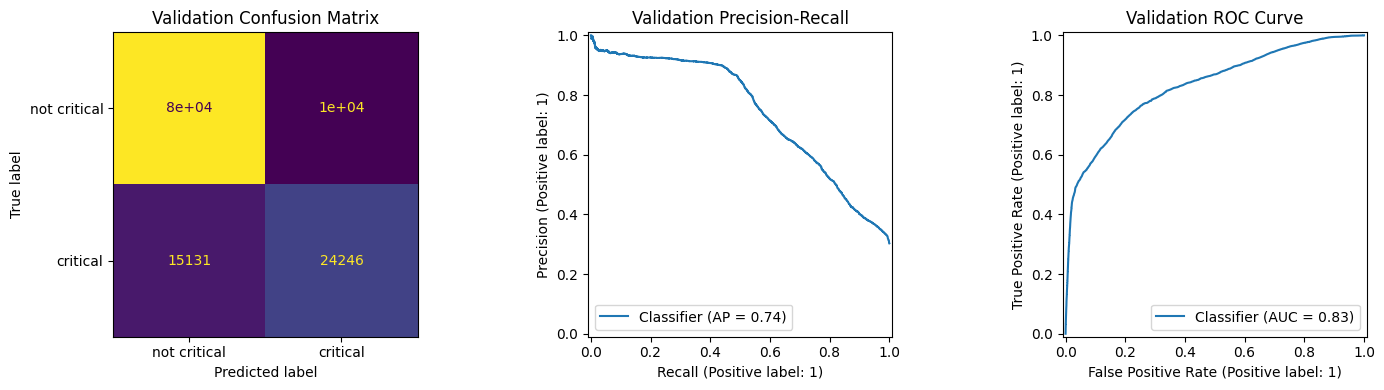

[Test] threshold=0.500
              precision    recall  f1-score   support

           0      0.825     0.852     0.838     89173
           1      0.668     0.622     0.644     42676

    accuracy                          0.777    131849
   macro avg      0.746     0.737     0.741    131849
weighted avg      0.774     0.777     0.775    131849

AUC-PR: 0.7394 | AUC-ROC: 0.8150


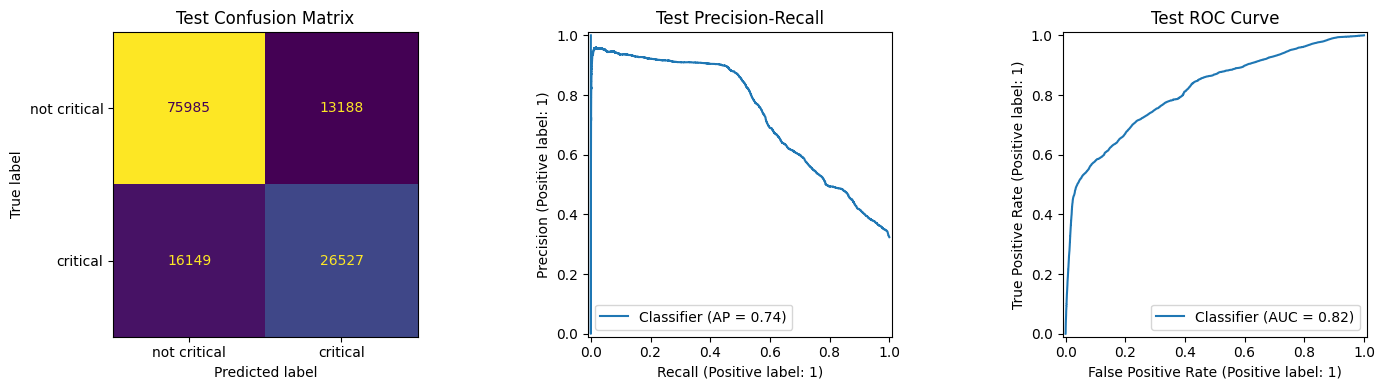

In [6]:
# 5. Train & Evaluate
# ------------------------------------------------------------------------------
print("Training Logistic Regression...")
model.fit(X_train, y_train)
print("Training Complete.")

def evaluate_split(X, y, split_name: str, threshold: float = 0.5):
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)
    pr_auc = average_precision_score(y, proba)
    roc_auc = roc_auc_score(y, proba)

    print(f"[{split_name}] threshold={threshold:.3f}")
    print(classification_report(y, preds, digits=3, zero_division=0))
    print(f"AUC-PR: {pr_auc:.4f} | AUC-ROC: {roc_auc:.4f}")

    cm = confusion_matrix(y, preds)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"{split_name} Precision-Recall")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[2])
    axes[2].set_title(f"{split_name} ROC Curve")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": pr_auc, "auc_roc": roc_auc, "confusion": cm.tolist()}

val_metrics = evaluate_split(X_val, y_val, "Validation", threshold=0.5)
test_metrics = evaluate_split(X_test, y_test, "Test", threshold=0.5)


In [7]:
# 6. Feature Importance (Check if timestamps matter)
# ------------------------------------------------------------------------------
cat_names = model.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(SAFE_CATEGORICAL_COLS)
final_feature_names = SAFE_NUMERIC_COLS + list(cat_names)
coeffs = model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'feature': final_feature_names,
    'coefficient': coeffs,
    'abs_coeff': np.abs(coeffs)
}).sort_values(by='abs_coeff', ascending=False)

print("\nTop 10 Overall Features:")
print(coef_df.head(10))


Top 10 Overall Features:
                          feature  coefficient  abs_coeff
15             hist_critical_frac     1.289091   1.289091
18             hist_cpu_mean_mean     0.289503   0.289503
23        vm_category_Interactive     0.171391   0.171391
12                     hist_n_vms     0.145224   0.145224
13                hist_n_critical    -0.137462   0.137462
8             log_deployment_size     0.125455   0.125455
20            hist_frac_gt60_mean    -0.112085   0.112085
24             vm_category_Unkown    -0.101593   0.101593
22  vm_category_Delay-insensitive    -0.094469   0.094469
9               count_vms_created    -0.082556   0.082556


c:\Users\dpnim\miniconda3\envs\machine_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



STARTING LOGISTIC REGRESSION OPTIMIZATION
1. Calculating Baseline Performance...
   Baseline Validation AUC: 0.83187
2. Computing Permutation Importance...


   > Found 9 non-predictive features (Importance <= 0).
3. Checking for Multicollinearity (>0.95)...
   > Found 3 highly correlated features.

DROPPING 9 FEATURES: ['ts_vm_created', 'deployment_size', 'hist_has_past', 'vm_mem_per_core', 'vm_memory_gb', 'hist_lifetime_std', 'hist_lifetime_mean', 'ts_first_vm_created', 'sub_first_day']

Retraining Logistic Regression with 13 numeric and 1 categorical features...
Training Complete.

FINAL OPTIMIZED PERFORMANCE REPORT
Selected Threshold: 0.4143
ROC AUC:  0.8123
PR AUC:   0.7374
Max F1:   0.6456
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.8367    0.8037    0.8199     89173
           1     0.6211    0.6721    0.6456     42676

    accuracy                         0.7611    131849
   macro avg     0.7289    0.7379    0.7327    131849
weighted avg     0.7669    0.7611    0.7635    131849



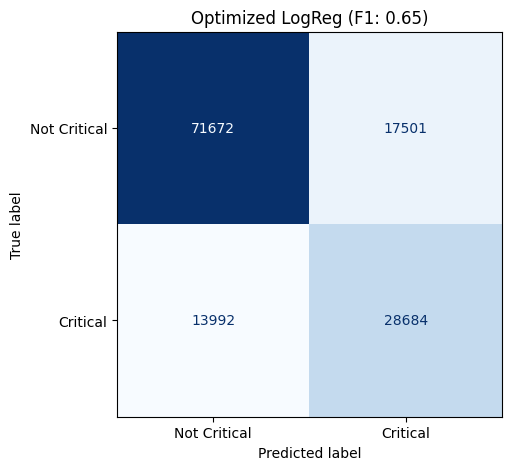


Top 10 Influential Features (Optimized):
                          Feature      Coef
8              hist_critical_frac  1.285881
9              hist_cpu_mean_mean  0.349845
11            hist_frac_gt60_mean -0.190434
3             log_deployment_size  0.140185
14        vm_category_Interactive  0.106023
13  vm_category_Delay-insensitive -0.095425
4               count_vms_created -0.079663
15             vm_category_Unkown -0.055513
7                 hist_n_critical  0.048428
0                         day_idx -0.023443


In [8]:
# ==============================================================================
# AUTOMATED FEATURE SELECTION & RETRAINING BLOCK (LOGISTIC REGRESSION)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

print("\n" + "="*50)
print("STARTING LOGISTIC REGRESSION OPTIMIZATION")
print("="*50)

# 1. Calculate Baseline Performance
# ------------------------------------------------------------------------------
print("1. Calculating Baseline Performance...")
base_probas = model.predict_proba(X_val)[:, 1]
base_auc = roc_auc_score(y_val, base_probas)
print(f"   Baseline Validation AUC: {base_auc:.5f}")

# 2. Permutation Feature Importance
# ------------------------------------------------------------------------------
# We shuffle raw features *before* the pipeline to test true importance
all_features = SAFE_NUMERIC_COLS + SAFE_CATEGORICAL_COLS
importances = {}

print("2. Computing Permutation Importance...")
for feat in tqdm(all_features, desc="Permuting features", leave=False):
    X_val_perm = X_val.copy()
    X_val_perm[feat] = np.random.permutation(X_val_perm[feat].values)
    
    # Predict with permuted feature
    perm_probas = model.predict_proba(X_val_perm)[:, 1]
    perm_auc = roc_auc_score(y_val, perm_probas)
    
    # Importance = Baseline - Permuted (Positive is good)
    importances[feat] = base_auc - perm_auc

# Identify zero/negative importance features
zero_imp_feats = [k for k, v in importances.items() if v <= 0.0]
print(f"   > Found {len(zero_imp_feats)} non-predictive features (Importance <= 0).")

# 3. Correlation Analysis (Multicollinearity)
# ------------------------------------------------------------------------------
# Logistic Regression is sensitive to multicollinearity
print("3. Checking for Multicollinearity (>0.95)...")
corr_matrix = X_train[SAFE_NUMERIC_COLS].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_feats = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"   > Found {len(high_corr_feats)} highly correlated features.")

# 4. Construct Drop List
# ------------------------------------------------------------------------------
drop_candidates = set(zero_imp_feats + high_corr_feats)

# Safety: Don't drop all features
if len(drop_candidates) == len(all_features):
    print("   ! Warning: Analysis suggested dropping ALL features. Backing off to safe mode.")
    drop_candidates = set(zero_imp_feats)

# Logic: Prefer 'log' versions if correlated
if "deployment_size" in drop_candidates and "log_deployment_size" in drop_candidates:
    drop_candidates.remove("log_deployment_size")

final_drop_list = list(drop_candidates)
print(f"\nDROPPING {len(final_drop_list)} FEATURES: {final_drop_list}")

# 5. Retraining
# ------------------------------------------------------------------------------
# Filter feature lists
OPT_NUM_COLS = [c for c in SAFE_NUMERIC_COLS if c not in final_drop_list]
OPT_CAT_COLS = [c for c in SAFE_CATEGORICAL_COLS if c not in final_drop_list]

print(f"\nRetraining Logistic Regression with {len(OPT_NUM_COLS)} numeric and {len(OPT_CAT_COLS)} categorical features...")

# Rebuild Preprocessor with optimized columns
# We must recreate the transformer to handle the reduced feature set
opt_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, OPT_NUM_COLS),
        ('cat', categorical_transformer, OPT_CAT_COLS)
    ]
)

# Rebuild Pipeline
opt_model = Pipeline(steps=[
    ('preprocessor', opt_preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        solver='lbfgs', 
        random_state=42
    ))
])

# Fit
opt_model.fit(X_train, y_train)
print("Training Complete.")

# 6. Final Evaluation
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("FINAL OPTIMIZED PERFORMANCE REPORT")
print("="*50)

# Get probabilities
test_probas = opt_model.predict_proba(X_test)[:, 1]

# Metrics
roc_auc = roc_auc_score(y_test, test_probas)
pr_auc = average_precision_score(y_test, test_probas)

# Find Optimal Threshold (Maximize F1)
precisions, recalls, thresholds = precision_recall_curve(y_test, test_probas)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Hard predictions
final_preds = (test_probas >= best_thresh).astype(int)

print(f"Selected Threshold: {best_thresh:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")
print(f"PR AUC:   {pr_auc:.4f}")
print(f"Max F1:   {best_f1:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, final_preds, digits=4))

# Visuals
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Critical", "Critical"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f"Optimized LogReg (F1: {best_f1:.2f})")
plt.show()

# Show Top Coefficients of Optimized Model
try:
    # Extract feature names from the pipeline
    # Numeric are passed through, Categorical are one-hot encoded
    ohe_feature_names = opt_model.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(OPT_CAT_COLS)
    final_feature_names = OPT_NUM_COLS + list(ohe_feature_names)
    
    coeffs = opt_model.named_steps['classifier'].coef_[0]
    
    coef_df = pd.DataFrame({
        'Feature': final_feature_names,
        'Coef': coeffs,
        'Abs_Coef': np.abs(coeffs)
    }).sort_values(by='Abs_Coef', ascending=False).head(10)
    
    print("\nTop 10 Influential Features (Optimized):")
    print(coef_df[['Feature', 'Coef']])
except Exception as e:
    print(f"\nCould not extract coefficients: {e}")